# Schooling in Xenopus tadpoles: Power analysis

This is a supplementary notebook that generates some simulated data, and estimates the power analysis for a schooling protocol. The analysis subroutines are the same, or very close to ones from the actual notebook (**schooling_analysis**). The results of power analysis are given, and explained, in the text below, but can also be re-created by the reader, by re-running this notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial
import scipy.stats as stats
from typing import List,Tuple

## 1. Generate simulated data

Data is generated in the following format:

    Layout of Tadpole dataframe:
           x       y     tx    ty
    0  7.391  14.783 -0.159 -0.14
    1  8.850  14.623 -0.180 -0.18
    2  7.751  12.426 -0.260 -0.24

where each line correponds to a "tadpole"; `x` and `y` columns give the position of the "tadpole's head" (virtual, in this case), and `tx` and `ty` are the positions of the "tail", relative to the "head". 

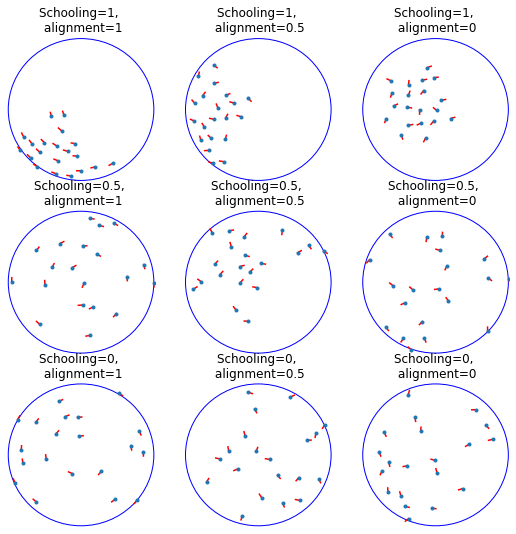

In [935]:
def simulate_data(ntads=10, schooling=0.5, alignment=0.6):
    """Simulates tadpole distribution in the dish.
    n = how many tadpoles to have
    
    schooling = the probability of being in a school (simplistic, binary approach)
    r = aligment radius
    alignment = alignment coefficient (1-noise_level)
    """
    
    R_DISH = 7
    TAD_LENGTH = 0.4
    N_ATTEMPTS = 20         # How many attempts to place each tadpole we would make
    JUMP = 1                # Jump, in cm, from one tadpole to another
    do_alignment = False    # Whether we should align tadpoles to their neighbors. Too fancy?
    
    xy = np.zeros((ntads,2))
    tails = np.zeros((ntads,2))
    
    itad = 0
    while itad < ntads: # Simplified Bridson’s algorithm for Poisson-disc sampling
        if itad==0 or np.random.uniform()>schooling: # First point and non-schooled points placed at random
            drop = np.random.uniform(0, 2*R_DISH, 2)
        else:
            iparent = np.random.randint(itad)
            angle = np.random.uniform(0, 2*np.pi)
            d = np.random.uniform(JUMP, 2*JUMP)
            drop = xy[iparent,:] + np.array([np.cos(angle), np.sin(angle)])*d
        if np.sqrt((drop[0]-R_DISH)**2 + (drop[1]-R_DISH)**2) > R_DISH: # Outside of a dish, won't do
            continue
        good_point = True
        for iother in range(itad):
            if np.sqrt(np.sum(np.square(drop-xy[iother,:]))) < JUMP:    # Too close to another dot; won't do
                good_point = False
                break
        if not good_point:
            continue
        xy[itad,:] = drop
        
        # Make the tadpole perpendicular to the radius
        tails[itad,:] = [xy[itad,1]-R_DISH, -xy[itad,0]+R_DISH]
        tails[itad,:] = tails[itad,:]/np.linalg.norm(tails[itad,:])*TAD_LENGTH
        if do_alignment: # Fancy mutual alignment; maybe don't use it, as it is too fancy?
            if itad>0:
                for iother in range(itad):
                    d = np.linalg.norm(xy[itad,:]-xy[iother,:])
                    tails[itad,:] += tails[iother,:]/(d**2)
            tails[itad,:] = tails[itad,:]/np.linalg.norm(tails[itad,:])*TAD_LENGTH
        angle = np.random.uniform(0, 2*np.pi)
        randotail = np.array([np.cos(angle), np.sin(angle)])*TAD_LENGTH
        tails[itad,:] = tails[itad,:]*alignment + randotail*(1-alignment)
        tails[itad,:] = tails[itad,:]/np.linalg.norm(tails[itad,:])*TAD_LENGTH
        # This code above with 3 normalizations in a row could have been prettier of course
            
        itad += 1
       
    return pd.DataFrame({'x':xy[:,0] , 'y':xy[:,1] , 'tx':tails[:,0] , 'ty':tails[:,1]})  

def arena_plot(t):
    for i in range(len(t)):
        plt.plot(t.x[i]+np.array([0, t.tx[i]]), t.y[i]+np.array([0, t.ty[i]]), 'r-')
    plt.plot(t.x, t.y, '.')
    plt.gca().add_artist(plt.Circle((7,7), 6.9, color='blue', fill=False, linestyle='-'))
    plt.xlim([0, 14])
    plt.ylim([0, 14])
    plt.axis('off')
    return

schoolings = [1, 0.5, 0]
alignments = [1, 0.5, 0]
names = ['Lawful', 'Neutral', 'Chaotic', 'good', 'neutral', 'evil']
plt.figure(figsize=(9,9))
for i in range(3):
    for j in range(3):
        t = simulate_data(ntads=20, schooling=schoolings[i], alignment=alignments[j])
        plt.subplot(3,3,i*3+j+1)
        arena_plot(t)
        plt.title(f"Schooling={schoolings[i]}, \n alignment={alignments[j]}")
        #plt.title(names[j] + ' ' + names[3+i])

## 2. Processing Tools

An exact copy of tools from the "main notebook" (as of 2020.08.01), except that instead of extracing tadpoles from real data, here we simulate this data. (So `exctractTads` function is not actually used).

Layout of Tadpole dataframe:
           x          y        tx        ty
0  12.972282   9.730947 -0.111329 -0.384195
1  11.880166  10.630500  0.391904 -0.080068
2   6.528482  13.566266  0.391893  0.080126

Layout of Pairs dataframe:
    i   j      dist
0  19   5  2.737425
1   5   7  1.183917
2   7  19  3.604447


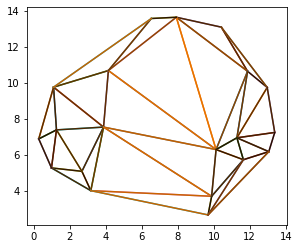

In [846]:
def getNFrames(data):
    """Returns the total number of frames."""
    return max(data.Frame)+1

def extractTads(data,frame):
    """Splits the data into XY position of each head, and _relative_ XY position of each tail."""
    xy = data.loc[data.Frame==frame,['X','Y']].to_numpy()
    heads = xy[0::2,:]
    tails = xy[1::2,:]-heads
    return pd.DataFrame({'x':heads[:,0] , 'y':heads[:,1] , 'tx':tails[:,0] , 'ty':tails[:,1]})  

def findNeighbors(tads): # Returns a new data frame, for edges
    """Triangulates the field, finds "neighbors". No thresholding of distance."""
    xy = tads[['x','y']]
    tri = scipy.spatial.Delaunay(xy,qhull_options="QJ").simplices # "QJ" is needed to retain
                                                                  # all tadpoles, including isolated ones
    listOfPairs = [] # Array of tuples to describe all pairs of points
    flip = lambda x: (x[1],x[0])  # A local function to flip tuples
    for i in range(tri.shape[0]): # Go through all edges of Delaunay triangles, include each one only once
        triangle = [tuple(tri[i,[0,1]]) , tuple(tri[i,[1,2]]) , tuple(tri[i,[2,0]])]
        for p in triangle:
            if p not in listOfPairs and flip(p) not in listOfPairs:
                listOfPairs += [p]
    out = pd.DataFrame({'i':[a for (a,b) in listOfPairs] , 'j':[b for (a,b) in listOfPairs]})
    return out

def findDistances(tads,pairs):
    """Calculates distances between pairs of neighboring tadpoles."""
    xy = tads[['x','y']].values
    dist = [np.linalg.norm(xy[p[0],]-xy[p[1],]) for p in pairs[['i','j']].values.tolist()]
    pairs['dist'] = dist
    return pairs

# --- Test, for the first frame
tads = simulate_data(ntads=20)
pairs = findNeighbors(tads)
pairs = findDistances(tads,pairs)

print('Layout of Tadpole dataframe:')
print(tads[:3])
print('\nLayout of Pairs dataframe:')
print(pairs[:3])

# Test figure with edge colors proportional to their distance
fig = plt.figure()
ax = fig.add_subplot(111)
xy = tads[['x','y']].values
for i in range(len(pairs)):
    p = pairs[['i','j']].values.tolist()[i]
    ax.plot([xy[p[0],0] , xy[p[1],0]],[xy[p[0],1] , xy[p[1],1]]) # Point
    ax.plot(*([xy[p[i],_] for i in range(2)] for _ in range(2)),
           color=np.array([1,0.5,0])*pairs['dist'].iloc[i]/pairs[['dist']].max().values*0.9) 
    # The awkward construction above draws lines between neighboring tadpoles
ax.set_aspect('equal')

## 3. Tools to Process Angles

Exactly same as in the main notebook (as of 2020.08.01)

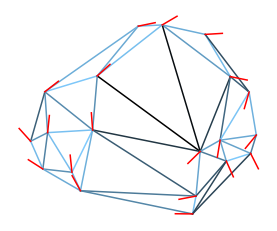

In [847]:
def findAngles(tads,pairs):
    '''Angles between pairs of tadpoles'''
    tails = tads[['tx','ty']].values # Go from pandas to lists, to utilize list comprehension
    norms = [np.linalg.norm(tails[i,]) for i in range(tails.shape[0])]
    angle = [np.arccos(np.dot(tails[p[0],],tails[p[1],])/(norms[p[0]]*norms[p[1]])) 
             for p in pairs[['i','j']].values.tolist()]
    pairs['angle'] = np.array(angle)/np.pi*180
    return pairs

def niceTadFigure(ax,tads,pairs):
    """Nice picture for troubleshooting."""
    xy = tads[['x','y']].values
    tails = tads[['tx','ty']].values
    ang = pairs[['angle']].values
    for i in range(len(pairs)):
        p = pairs[['i','j']].values.tolist()[i]
        ax.plot(*([xy[p[i],_] for i in range(2)] for _ in range(2)),
           color=np.array([0.5,0.8,1])*(1-ang[i]/max(ang))) # Tadpole-tapole Edges
    for i in range(xy.shape[0]):
        nm = np.linalg.norm(tails[i,])
        ax.plot(xy[i,0]+[0,tails[i,0]/nm], xy[i,1]+[0,tails[i,1]/nm] , '-',color='red')
    ax.set_aspect('equal')
    ax.axis('off')

# --- Test, for the first frame
pairs = findAngles(tads,pairs)
    
fig = plt.figure()
ax = fig.add_subplot(111)
niceTadFigure(ax,tads,pairs)
#plt.savefig('crystal_pic.svg', format='svg')

## 4. Define full processor and dataset visualization

This function is adjusted to look like the procesisng function from the main notebook, but actually we call the simulation several times, to generate the "frames".

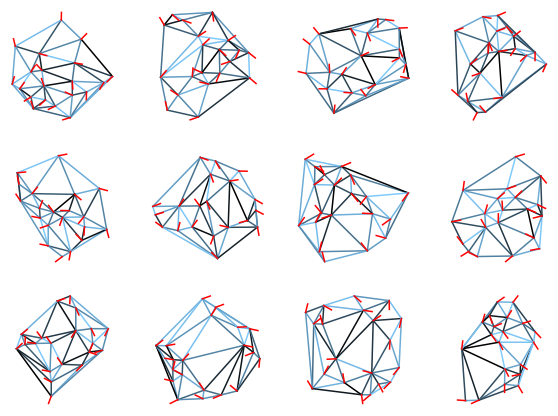

In [925]:
def processEverything(nsets=12, show_image=False, schooling=0.3, alignment=0.5):
    """Process one full dataset."""
    if show_image:
        fig = plt.figure(figsize=(10,10));

    fullDf = pd.DataFrame()
    for iframe in range(nsets):
        tads = simulate_data(ntads=20, schooling=schooling, alignment=alignment)
        pairs = findNeighbors(tads)
        pairs = findDistances(tads,pairs)
        angl = findAngles(tads,pairs)

        fullDf = fullDf.append(pd.DataFrame({'frame': [iframe]*len(pairs)}).join(pairs))

        if show_image:
            ax = fig.add_subplot(4,4,iframe+1)
            niceTadFigure(ax,tads,pairs)
    return fullDf
    
out = processEverything(show_image=True)

## 5. Compare two different simulated datasets

Below, one dataset has high schooling coefficient (0.9), and perfect alignment (1.0), while the other has almost no schooling (0.1), and perfectly random orientation for all tadpoles (alignment=0.0).

In [939]:
# Prepare the data
out = processEverything(show_image=False, schooling=0.9, alignment=1.0)
out_treatment = processEverything(show_image=False, schooling=0.1, alignment=0.0)

Was the average inter-tadpole disctance different between two sets of data?
(were their clumping?)
T-test: t =  -7.081288975811951 ; p-value =  2.4422756226026123e-12

Was the distribution shape different between two sets??
Kolmogorov-Smirnov test p-value =  7.172521035283853e-31


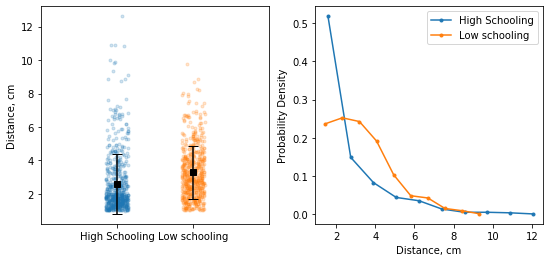

In [940]:
def two_groups_plot(y1, y2, labels):
    """A basic two-groups plot"""
    plt.plot(1+(np.random.uniform(size=y1.shape[0])-0.5)*0.3, y1, '.', alpha=0.2, zorder=-1)
    plt.plot(2+(np.random.uniform(size=y2.shape[0])-0.5)*0.3, y2, '.', alpha=0.2, zorder=-1)
    # Zorder is set to negative to hack around a bug in matplotlib that places errorbars below plots
    plt.errorbar(1, np.mean(y1), np.std(y1), color='k', marker='s', capsize=5)
    plt.errorbar(2, np.mean(y2), np.std(y2), color='k', marker='s', capsize=5)
    plt.xlim(0,3)
    plt.xticks(ticks=[1,2], labels=labels)

def compare_distances(out1,out2,labels):
    """Visualizes distances, reports a stat test"""
    N_BINS = 10
    
    d = out1['dist'].values
    d2 = out2['dist'].values

    plt.figure(figsize=(9,4))
    ax = plt.subplot(121)
    two_groups_plot(d, d2, labels)
    plt.ylabel('Distance, cm')
    
    ax = plt.subplot(122)
    #plt.hist(d , bins=30, density=True, alpha=0.5);
    #plt.hist(d2, bins=30, density=True, alpha=0.5);
    y1,x1 = np.histogram(d, bins=N_BINS, density=True)
    y2,x2 = np.histogram(d2, bins=N_BINS, density=True)
    centers = lambda x: np.mean(np.vstack((x[:-1],x[1:])), axis=0) # Centers of each bin
    plt.plot(centers(x1),y1,'.-')
    plt.plot(centers(x2),y2,'.-')
    plt.xlabel('Distance, cm')
    plt.ylabel('Probability Density')
    plt.legend(labels, loc='upper right')

    print('Was the average inter-tadpole disctance different between two sets of data?')
    print('(were their clumping?)')
    test_results = stats.ttest_ind(d,d2)
    print('T-test: t = ', test_results.statistic, '; p-value = ',test_results.pvalue)

    print('\nWas the distribution shape different between two sets??')
    test_results = scipy.stats.ks_2samp(d,d2)
    print('Kolmogorov-Smirnov test p-value = ',test_results.pvalue)

compare_distances(out, out_treatment, ['High Schooling','Low schooling'])
#plt.savefig('distances.svg', format='svg')

As we can see, non-schooling tadpoles tend to be more uniformly distributed, so we observe more mid-distances and fewer low and high distances. ("More uniformly" doesn't mean that the distribution is actually uniform; it is expected to be closer to $χ^2$). Conversely, schooling tadpoles tend to be closer to each other.

As not all inter-tadpole distances were considered, but rather we rely on the Delaunay triangulation, the shape of the histogram may be rather peculiar, but it is OK. What matters is not the shape itself, but the fact that this shape is sensitive to the configuration of the swarm, as this means that it can be used to statistically compare swarms that were formed differently.


Was the distribution of angles different between two sets?
Kolmogorov-Smirnov test p-value =  3.767828784543536e-73


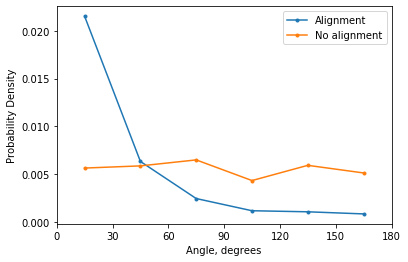

In [941]:
def compare_angles(out, out2, labels):
    """Visualizes angles, reports a stat test."""
    HIST_BIN = 30 # Histogram step, in degrees
    
    a = out['angle'].values
    a2 = out2['angle'].values

    #plt.hist(a , bins=np.arange(0,180+10,10), density=True, alpha=0.5);
    #plt.hist(a2, bins=np.arange(0,180+10,10), density=True, alpha=0.5);
    
    preset_bins = np.arange(0,180+HIST_BIN, HIST_BIN)    
    y1,x1 = np.histogram(a,  bins=preset_bins, density=True)
    y2,x2 = np.histogram(a2, bins=preset_bins, density=True)
    centers = lambda x: np.mean(np.vstack((x[:-1],x[1:])), axis=0) # Centers of each bin
    plt.plot(centers(x1),y1,'.-')
    plt.plot(centers(x2),y2,'.-')
    plt.xticks(np.arange(0,180+30,30))
    plt.xlabel('Angle, degrees')
    plt.ylabel('Probability Density')
    plt.legend(labels, loc='upper right')

    print('\nWas the distribution of angles different between two sets?')
    test_results = scipy.stats.ks_2samp(a,a2)
    print('Kolmogorov-Smirnov test p-value = ',test_results.pvalue)
    
compare_angles(out, out_treatment, ['Alignment','No alignment'])
#plt.savefig('angles.svg', format='svg')

As we can see, if tadpoles are oriented at random, the histogram of inter-tadpole angles is flat. If tadpoles school, the distribution of angles drops, as most tadpoles are co-oriented.

## 6. Power analysis

In [896]:
ntries = 50

x = np.linspace(0, 1, 21)
y = np.zeros((x.shape[0], 3))
for ival in range(len(x)):
    val = x[ival]
    print(f'{val:4.1f}', end=' ')
    count = np.array([0,0,0])
    for iattempt in range(ntries):
        print('.', end='')
        out1 = processEverything(show_image=False, schooling=0.5, alignment=0.5)
        out2 = processEverything(show_image=False, schooling=val, alignment=val)
        d = out1['dist'].values
        d2 = out2['dist'].values
        pttest = stats.ttest_ind(d,d2).pvalue
        pks = scipy.stats.ks_2samp(d,d2).pvalue
        pangles = scipy.stats.ks_2samp(out['angle'].values, out2['angle'].values).pvalue
        count[0] += 1*(pttest<0.05)
        count[1] += 1*(pks<0.05)
        count[2] += 1*(pangles<0.05)
    y[ival,:] = count/ntries
    print()

 0.0 ..................................................
 0.1 ..................................................
 0.1 ..................................................
 0.2 ..................................................
 0.2 ..................................................
 0.2 ..................................................
 0.3 ..................................................
 0.4 ..................................................
 0.4 ..................................................
 0.5 ..................................................
 0.5 ..................................................
 0.6 ..................................................
 0.6 ..................................................
 0.7 ..................................................
 0.7 ..................................................
 0.8 ..................................................
 0.8 ..................................................
 0.9 ...........................................

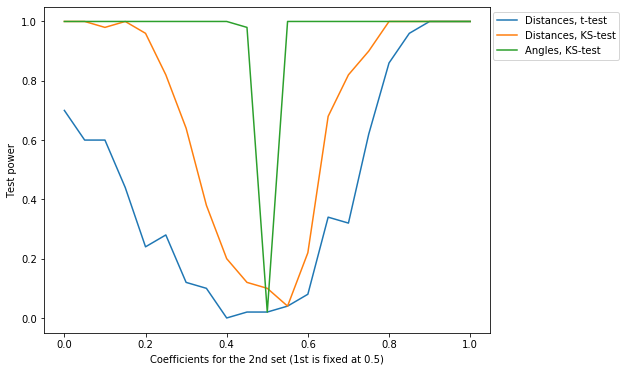

In [898]:
plt.figure(figsize=(8,6));
plt.plot(x,y);
plt.legend(labels=["Distances, t-test","Distances, KS-test","Angles, KS-test"], bbox_to_anchor=(1.3, 1));
plt.xlabel('Coefficients for the 2nd set (1st is fixed at 0.5)');
plt.ylabel('Test power');

For every point of the chart above, we compare two simulated datasets. One has the **schooling** coefficient (the probability of joining an existing school) set at 0.5, and the admixture of noise to tadpole orientation (**alignment** coefficient) also set at 0.5. For the other dataset, both parameters assume all values from 0 to 1 with a 0.05 step. The sizes of both datasets are the same as in our real experiments: 20 tadpoles, 12 photos. each simulation is repeated 50 times, to estimate the power 1-β of each of the tests (with α=0.05).

We can see that the angle analysis is much more sensitive, as even a change from 0.50 to 0.55 noise admixture is detected with >95% probability. Yet, the distribution of angles is also arguably more biologically involved, as it can depend on the function of the lateral line, and the distribution of currents in the bowl, while these currents may themselves be affected by the quality of schooling (non-schooling tadpoles won't create a current). To re-iterate, the test for co-alignment is very sensitive mathematically, but may be a bit messy biologically.

The tests of spatial clumping are almost exactly the other way around: they are easy to interpret (if the tadpoles stay together, then phenomenologially the DO schoo, regardless of the mechanism), but they are not that sensitive mathematically. For this sample size, we had to change the probability of "not joining a school" by about 30% to detect a difference with 80% power. We can also see that the t-test is more sensitive to this change than the Kolmogorov-Smirnov test, although this comparison may be sensitive to this particular implementation of a spatial model.